In [2]:
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.0 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [3]:
!pip install plyfile

In [18]:
%reset -f

In [6]:
!unzip pipe_segmentations.zip

Archive:  pipe_segmentations.zip
   creating: pipe_segmentations/
  inflating: pipe_segmentations/2024-09-02_155419_243301-12_tray-b-4-a_L2_part_1_downsample_10_without_ears_seg_basis.ply  
  inflating: pipe_segmentations/2024-09-02_155419_243301-12_tray-b-4-a_L2_part_1_downsample_10_without_ears_seg_pipes.ply  
  inflating: pipe_segmentations/2024-09-02_155419_243301-12_tray-b-4-a_L2_part_2_downsample_10_without_ears_seg_basis.ply  
  inflating: pipe_segmentations/2024-09-02_155419_243301-12_tray-b-4-a_L2_part_2_downsample_10_without_ears_seg_pipes.ply  
  inflating: pipe_segmentations/2024-09-02_155419_243301-12_tray-b-4-a_L2_part_3_downsample_10_without_ears_seg_basis.ply  
  inflating: pipe_segmentations/2024-09-02_155419_243301-12_tray-b-4-a_L2_part_3_downsample_10_without_ears_seg_pipes.ply  
  inflating: pipe_segmentations/2024-09-02_155419_243301-12_tray-b-4-a_L2_part_4_downsample_10_without_ears_seg_basis.ply  
  inflating: pipe_segmentations/2024-09-02_155419_243301-12_tray-b

In [19]:
import torch
import torch.nn as nn
import open3d as o3d
import numpy as np
import os
from torch.utils.data import DataLoader, Dataset
from sklearn.decomposition import PCA
from plyfile import PlyData, PlyElement
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [20]:
def load_ply_files(folder_path):
    ply_files = []
    for filename in os.listdir(folder_path):
        if filename.endswith('seg_pipes.ply'):
            filepath = os.path.join(folder_path, filename)
            ply = o3d.io.read_point_cloud(filepath)
            ply_files.append(ply)
    print(f"Loaded {len(ply_files)} PLY files.")
    return ply_files


def compute_average_points(ply_files):
    total_points = 0
    num_files = len(ply_files)

    for pcd in ply_files:
        total_points += np.asarray(pcd.points).shape[0]  # Count points in each PLY file

    average_points = total_points / num_files
    return average_points


def normalize_point_cloud(points):
    # Center the points around the origin and scale them to unit variance
    centroid = np.mean(points, axis=0)
    points = points - centroid
    scale = np.max(np.linalg.norm(points, axis=1))
    points = points / scale
    return points


def preprocess_point_cloud(pcd, num_points=266808):
    pcd_points = np.asarray(pcd.points)
    pcd_colors = np.asarray(pcd.colors)

    if len(pcd_points) < num_points:
        # If there are fewer points, pad with zeros
        padded_points = np.zeros((num_points, 3), dtype=np.float32)
        padded_points[:len(pcd_points)] = pcd_points

        padded_colors = np.zeros((num_points, 3), dtype=np.float32)
        padded_colors[:len(pcd_colors)] = pcd_colors

        return padded_points, padded_colors
    else:
        # Sample points if there are enough
        sampled_indices = np.random.choice(len(pcd_points), num_points, replace=False)
        sampled_points = pcd_points[sampled_indices]
        sampled_colors = pcd_colors[sampled_indices]

        return sampled_points, sampled_colors


class PointCloudDataset(Dataset):
    def __init__(self, ply_files, num_points=266808):
        self.ply_files = ply_files
        self.num_points = num_points

    def __len__(self):
        return len(self.ply_files)

    def __getitem__(self, idx):
        pcd = self.ply_files[idx]
        points, colors = preprocess_point_cloud(pcd, self.num_points)

        # Normalize the point cloud
        points = normalize_point_cloud(points)

        # Compute PCA features
        #pca = PCA(n_components=3)
        #pca_features = pca.fit_transform(points)

        # Combine points, PCA features, and colors into one tensor
        combined = np.concatenate((points, colors), axis=1)  # (num_points, num_features)
        return torch.tensor(combined, dtype=torch.float32)



class PointNetAutoencoder(nn.Module):
    def __init__(self):
        super(PointNetAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(6, 64, 1),
            nn.ReLU(),
            nn.Conv1d(64, 128, 1),
            nn.ReLU(),
            nn.Conv1d(128, 256, 1),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 266808 * 6)  # Output shape
        )

    def forward(self, x):
        # x shape (batch_size, num_points, num_features)
        x = x.transpose(1, 2)
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x.view(-1, 266808, 6)


def train_autoencoder(model, data_loader, criterion, optimizer, num_epochs=50, device='cpu'):
    model.train()
    all_coord_errors = []
    all_color_errors = []
    all_points = []  # Store points for later use

    for epoch in range(num_epochs):
        for data in data_loader:
            data = data.to(device)

            optimizer.zero_grad()

            reconstructed = model(data)  # Forward pass

            loss = criterion(reconstructed, data)  # Compute loss

            loss.backward()  # Backward pass

            optimizer.step()

            points = data[:, :, :3]  # Extract points (3D coordinates)
            colors = data[:, :, 3:]    # Extract colors (RGB)
            reconstructed_points = reconstructed[:, :, :3]  # Reconstructed points
            reconstructed_colors = reconstructed[:, :, 3:]    # Reconstructed colors

            coord_errors = torch.norm(points - reconstructed_points, dim=2)  # Euclidean distance for coordinates
            color_errors = torch.norm(colors - reconstructed_colors, dim=2)  # Euclidean distance for colors

            all_coord_errors.append(coord_errors)
            all_color_errors.append(color_errors)
            all_points.append(points)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Convert lists to tensors
    coord_errors = torch.cat(all_coord_errors, dim=0)
    color_errors = torch.cat(all_color_errors, dim=0)
    points = torch.cat(all_points, dim=0)  # Concatenate all points to be used later

    return coord_errors, color_errors, points

# Inliers and outliers detection
def inliers_outliers(coord_errors, color_errors, coord_threshold, color_threshold, points):
    coord_inliers = (coord_errors <= coord_threshold).nonzero()[:, 0]  # Extract indices from the tensor
    coord_outliers = (coord_errors > coord_threshold).nonzero()[:, 0]
    color_inliers = (color_errors <= color_threshold).nonzero()[:, 0]
    color_outliers = (color_errors > color_threshold).nonzero()[:, 0]

    print(f"Number of coord inliers: {len(coord_inliers)}")
    print(f"Number of coord outliers: {len(coord_outliers)}")
    print(f"Number of color inliers: {len(color_inliers)}")
    print(f"Number of color outliers: {len(color_outliers)}")
    return coord_inliers, coord_outliers, color_inliers, color_outliers

In [21]:
folder_path = '/content/pipe_segmentations'
ply_files = load_ply_files(folder_path)
average_points = compute_average_points(ply_files)

print(f"Average number of points: {average_points}")

Loaded 74 PLY files.
Average number of points: 266807.9054054054


In [22]:
# Create a dataset and dataloader
dataset = PointCloudDataset(ply_files)
data_loader = DataLoader(dataset)

# Initialize model, criterion, optimizer
device = torch.device("cuda")
model = PointNetAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

# Train the autoencoder
coord_errors, color_errors, points = train_autoencoder(model, data_loader, criterion, optimizer, num_epochs=100, device=device)

Epoch [1/100], Loss: 0.2977
Epoch [2/100], Loss: 0.1487
Epoch [3/100], Loss: 0.0878
Epoch [4/100], Loss: 0.0734


OutOfMemoryError: CUDA out of memory. Tried to allocate 262.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 135.06 MiB is free. Process 8019 has 14.61 GiB memory in use. Of the allocated memory 13.63 GiB is allocated by PyTorch, and 868.61 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

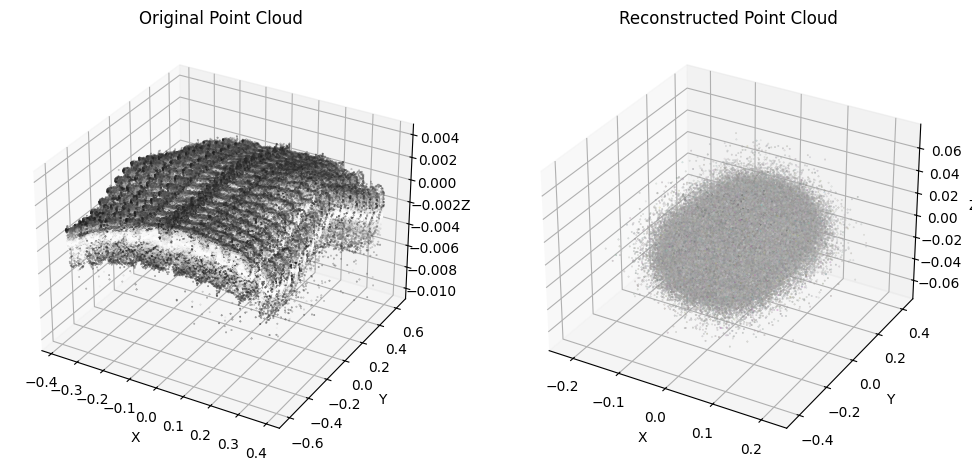

In [ ]:
def plot_point_cloud_3d(points, colors=None, title="Point Cloud", ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    x, y, z = points[:, 0], points[:, 1], points[:, 2]

    if colors is not None:
        ax.scatter(x, y, z, c=colors, marker='o', s=0.1)
    else:
        ax.scatter(x, y, z, marker='o', s=0.1)

    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

data_iter = iter(data_loader)
original_data = next(data_iter).to(device)

model.eval()

with torch.no_grad():
    reconstructed_data = model(original_data)

original_points = original_data[0, :, :3].cpu().numpy()
original_colors = original_data[0, :, 3:].cpu().numpy()
reconstructed_points = reconstructed_data[0, :, :3].cpu().numpy()
reconstructed_colors = reconstructed_data[0, :, 3:].cpu().numpy()

fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
plot_point_cloud_3d(original_points, colors=original_colors, title="Original Point Cloud", ax=ax1)

ax2 = fig.add_subplot(122, projection='3d')
plot_point_cloud_3d(reconstructed_data, title="Reconstructed Point Cloud", ax=ax2)

plt.show()